In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh
from fusiondls import run_dls, file_read, file_write
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach
from fusiondls.Profile import Profile


onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *

from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "50MW" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-01 - V10 Inner power scans for PSI\50MW\P50nu1p75e22Ar1e22Dpuff3e23r",
    "55MW" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-01 - V10 Inner power scans for PSI\55MW\P55nu1p75e22Ar1e22Dpuff3e23r",
    "60MW" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-01 - V10 Inner power scans for PSI\60MW\P60nu1p75e22Ar1e22Dpuff3e23r",
    "70MW" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-01 - V10 Inner power scans for PSI\70MW\P70nu1p75e22Ar1e22Dpuff3e23r",
    "80MW" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-01 - V10 Inner power scans for PSI\80MW",
    "90MW" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-01 - V10 Inner power scans for PSI\90MW",
    "100MW" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-01 - V10 Inner power scans for PSI\100MW\P100nu1p75e22Ar1e22Dpuff3e23_balanceadded",
    "120MW" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-01 - V10 Inner power scans for PSI\120MW\P120nu1p75e22Ar1e22Dpuff3e23r",
    # "150MW" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-01 - V10 Inner power scans for PSI\150MW\P150nu1p75e22Ar1e22Dpuff3e23r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")

50MW
Saving all states
Added total radiation, density and fraction for Ar
55MW
Saving all states
Added total radiation, density and fraction for Ar
60MW
Saving all states
Added total radiation, density and fraction for Ar
70MW
Saving all states
Added total radiation, density and fraction for Ar
80MW
Saving all states
Added total radiation, density and fraction for Ar
90MW
Saving all states
Added total radiation, density and fraction for Ar
100MW
Saving all states
Added total radiation, density and fraction for Ar
120MW
Saving all states
Added total radiation, density and fraction for Ar


# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [3]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for side in ["ol", "il", "ou", "iu"]:
        eqb[case][side] = dict()
        eqb_alt[case][side] = dict()
        for i in range(10):
            eqb[case][side][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = side, sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = {"ol":"outer_lower", "il":"inner_lower", "ou":"outer_upper", "iu":"inner_upper"}[side], sepadd = i)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][side][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

50MW
55MW
60MW
70MW
80MW
90MW
100MW
120MW


## Choose case

In [8]:
p = eqb_alt["100MW"]["ou"][3]

# Scale profiles

In [4]:
profiles = {}

## fR

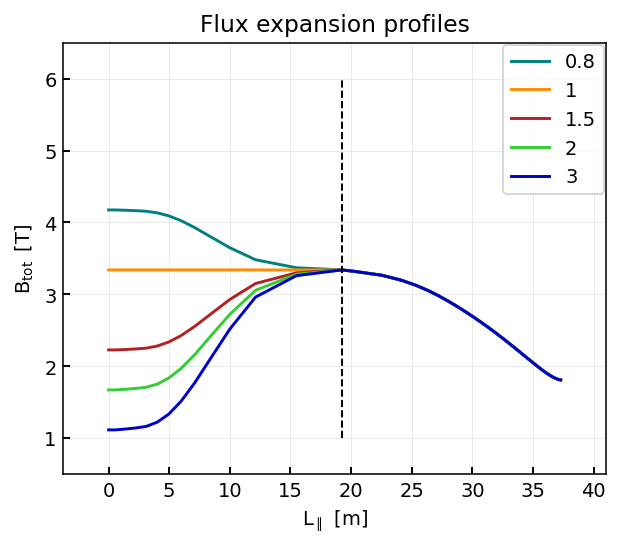

In [ ]:
from fusiondls.Profile import Profile

newp = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

list_bxbt = [0.8, 1, 1.5, 2, 3]
profiles_bxbt = {}

fig, ax = plt.subplots()

for bxbt in list_bxbt:
    profiles_bxbt[bxbt] = copy.deepcopy(newp)
    profiles_bxbt[bxbt].scale_BxBt(BxBt = bxbt)
    
    ax.plot(profiles_bxbt[bxbt]["S"], profiles_bxbt[bxbt]["Btot"], label = bxbt)
    
ax.vlines(newp["S"][newp["Xpoint"]], 1, 6, color = "k", lw = 1.0, linestyle = "--")
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

profiles["BxBt"] = profiles_bxbt

## Lc

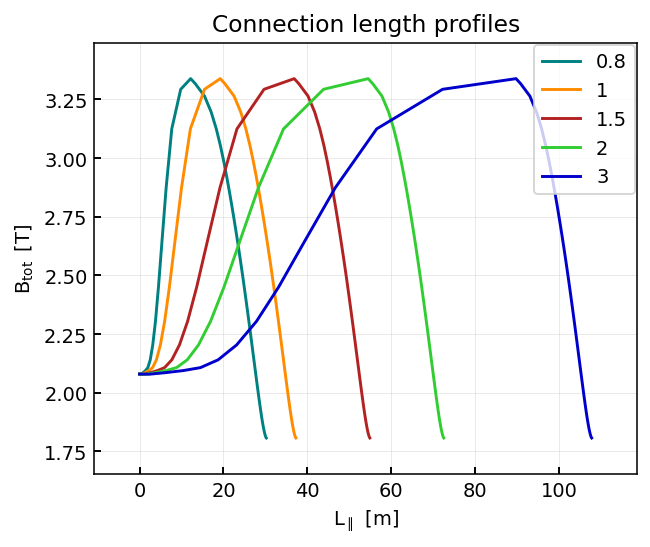

In [9]:
newp = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

list_Lc = [0.8, 1, 1.5, 2, 3]
profiles_Lc = {}

fig, ax = plt.subplots()

for Lc in list_Lc:
    profiles_Lc[Lc] = copy.deepcopy(newp)
    profiles_Lc[Lc].scale_Lc(scale_factor = Lc)
    
    p = profiles_Lc[Lc]
    ax.plot(profiles_Lc[Lc]["S"], profiles_Lc[Lc]["Btot"], label = Lc)
    # ax.plot(p["S"][p["Xpoint"]], p["Btot"][p["Xpoint"]], marker = "x", ms = 5, c = "k")
    
# ax.vlines(newp["S"][newp["Xpoint"]], 1, 6, color = "k", lw = 1.0, linestyle = "--")
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Connection length profiles")

profiles["Lc"] = profiles_Lc

## Save

In [10]:
store_profiles = {}
store_profiles["BxBt"] = profiles_bxbt

# Run

In [11]:
stores = {}

## fR

In [24]:
# set switches
radios_default = {
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 2.25e9 ,  # heat flux density at the x point
    "nu": 1e19,  # Upstream density (if constant)
    "nu0": 1e19,  # Upstream density (if constant)
    "cz0": 0.05,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbach("Ar"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

# Correct average Cz and qpar
constants_default["cz0"] = 0.09
constants_default["qpllu0"] = 0.8e9 

store_bxbt = dict()

for bxbt in list_bxbt:
    print(bxbt)
    d = profiles_bxbt[bxbt]

    try: 
            out = run_dls(
                constants = constants_default, 
                radios = radios_default, 
                d = d,
                SparRange = [0],
                control_variable = "density",
                verbosity = 0,
                Ctol = 1e-3,
                Ttol = 1e-3,
                dynamicGrid = True)
            
            store_bxbt[bxbt] = copy.deepcopy(out)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)
    print(out["cvar"])

0.8
Solving...0.00...Complete in 1.7 seconds
[4.722520848937792e+19]
1
Solving...0.00...Complete in 1.7 seconds
[4.115434348378492e+19]
1.5
Solving...0.00...Complete in 0.6 seconds
[3.1217816192812384e+19]
2
Solving...0.00...Complete in 1.5 seconds
[2.4903722913159844e+19]
3
Solving...0.00...Complete in 1.5 seconds
[1.7884071557148185e+19]


## Lc

In [13]:
# set switches
radios_default = {
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 2.25e9 ,  # heat flux density at the x point
    "nu": 1e19,  # Upstream density (if constant)
    "nu0": 1e19,  # Upstream density (if constant)
    "cz0": 0.05,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbach("Ar"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

# Correct average Cz and qpar
constants_default["cz0"] = 0.045
constants_default["qpllu0"] = 3.325e9

store_Lc = dict()

for Lc in list_Lc:
    print(Lc)
    d = profiles_Lc[Lc]

    try: 
            out = run_dls(
                constants = constants_default, 
                radios = radios_default, 
                d = d,
                SparRange = [0],
                control_variable = "density",
                verbosity = 0,
                Ctol = 1e-3,
                Ttol = 1e-3,
                dynamicGrid = True)
            
            store_Lc[bxbt] = copy.deepcopy(out)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)
    print(out["cvar"])

0.8
Solving...0.00...Complete in 1.1 seconds
[1.0744456125779136e+20]
1
Solving...0.00...Complete in 0.7 seconds
[9.525815303886517e+19]
1.5
Solving...0.00...Complete in 0.5 seconds
[7.72958750706905e+19]
2
Solving...0.00...Complete in 1.8 seconds
[6.69326680091271e+19]
3
Solving...0.00...Complete in 1.7 seconds
[5.4322748921261556e+19]


## Save

In [26]:
store_stores = {}
store_stores["BxBt"] = store_bxbt

# Profile plots

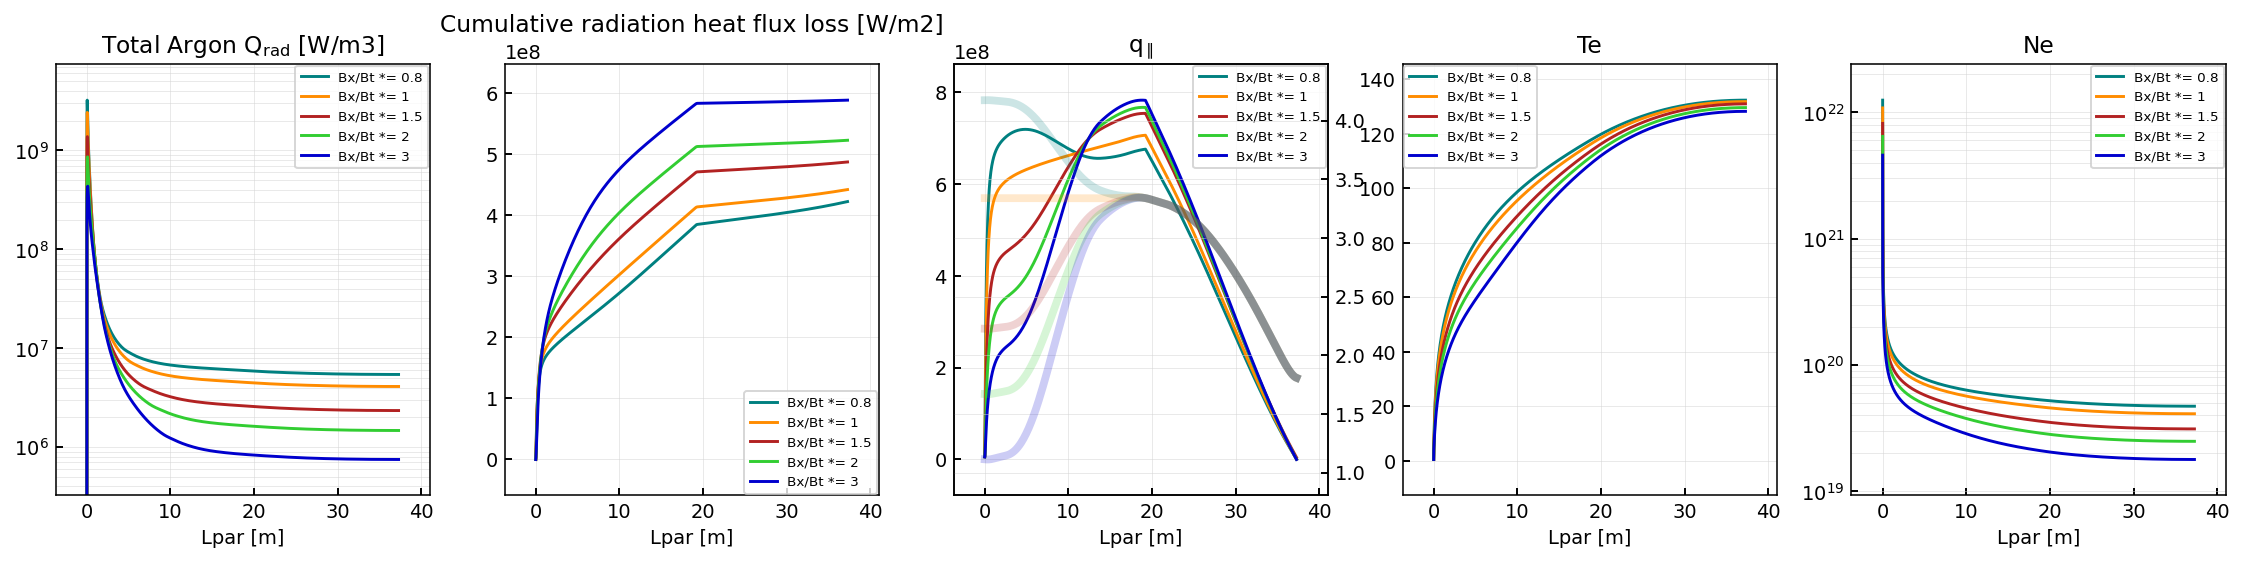

In [27]:
s = store_stores["BxBt"]

nfigs = 5
fsize = 4

fig, axes = plt.subplots(1,nfigs, figsize = (nfigs*fsize, fsize))
ax2 = axes[2].twinx()

for i in s:
    label = f"Bx/Bt *= {i}"
    
    out = s[i]
    
    ## DLS
    dlsR = out["Rprofiles"][0]
    dlsSpar = out["Sprofiles"][0]
    # dlsSpar = dlsSpar[-1] - dlsSpar 
    dlsTe = out["Tprofiles"][0]
    dlsqpar = out["Qprofiles"][0]
    dlsBtot = out["Btotprofiles"][0]
    dlsNe = out["cvar"][0] * dlsTe[-1] / dlsTe   ## Assuming cvar is ne
    qradial = out["state"].qradial
    
    Prad_per_area = np.gradient(dlsqpar/dlsBtot, dlsSpar) + qradial/dlsBtot
    Prad_per_area_cum = sp.integrate.cumulative_trapezoid(y = Prad_per_area, x = dlsSpar, initial = 0)  # W/m2
    Prad_per_area_cum_norm = Prad_per_area_cum / Prad_per_area_cum.max()

    ax = axes[0]
    ax.plot(dlsSpar, dlsR, label = label)
    ax.set_title("Total Argon $Q_{rad}$ [W/m3]")
    ax.set_yscale("log")

    ax = axes[1]
    ax.set_title("Cumulative radiation heat flux loss [W/m2]")

    ax.plot(dlsSpar, Prad_per_area_cum, label = label)

    ax = axes[2]
    ax.set_title("$q_{\parallel}$")
    ax.plot(dlsSpar, dlsqpar, label = label)
    
    ax2.plot(dlsSpar, dlsBtot, alpha = 0.2, lw = 4)
    # ax.set_yscale("log")

    ax = axes[3]
    ax.set_title("Te")
    ax.plot(dlsSpar, dlsTe, label = label)

    ax = axes[4]
    ax.set_title("Ne")
    ax.plot(dlsSpar, dlsNe, label = label)
    ax.set_yscale("log")


for ax in axes:
    ax.set_xlabel("Lpar [m]")
    ylims = ax.get_ylim()
    # ax.vlines(dfx["Spar"], *ylims, color = "darkslategrey", ls = "-", alpha = 0.5, lw = 1, label = "X-point")
    # ax.vlines(dffront["Spar"], *ylims, color = "deeppink", ls = "-", alpha = 0.3, lw = 1, label = "Front")
    ax.set_ylim(ylims)
    ax.legend(fontsize = "x-small")

# Analysis

## Flux expansion

In [33]:
profiles = store_profiles["BxBt"]
stores = store_stores["BxBt"]

df = get_detachment_scalings(profiles, stores)

In [35]:
def plot_threshcalcs(df, ax):
    
    scaling = df / df.iloc[0,:]
    out = {}
    
    out["simple"] = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
    out["simple_abovex"] = (scaling["Bf"]) * (scaling["W_Tu_simple"]) 
    out["add_Beff"] = (scaling["Btot_eff"]) * (scaling["W_Tu_simple"]) 
    out["add_W_Tu"] = (scaling["Btot_eff"]) * (scaling["W_Tu"])
    out["add_curveclip"] = (scaling["Btot_eff"]) * (scaling["W_Tu"]) * (scaling["int_TLz_dt"]) 
    out["add_upstream_rad"] = (scaling["Btot_eff"]) * (scaling["W_Tu"]) * (scaling["int_TLz_dt"]) * (scaling["int_qoverBsq_dt"])
    out["extended"] = (scaling["Btot_eff"]) * (scaling["W_Tu"]) * (scaling["int_TLz_dt"]) * (scaling["int_qoverBsq_dt"])
    
    # ax.plot(x, out["simple_abovex"], marker = "x", label = "DLS-Simple scaling", ms = ms, lw = 1.5)
    # ax.plot(x, scaling["Btot_eff"], marker = "x", label = "Beff only", ms = ms, lw = 1.5, ls = "--")
    # ax.plot(x, scaling["W_Tu"], marker = "x", label = "W_Tu only", ms = ms, lw = 1.5, ls = "--")
    # ax.plot(x, scaling["int_TLz_dt"], marker = "x", label = "int_TLz_dt only", ms = ms, lw = 1.5, ls = "--")
    # ax.plot(x, scaling["int_qoverBsq_dt"], marker = "x", label = "int_qoverBsq_dt only", ms = ms, lw = 1.5, ls = "--")
    # ax.plot(x, out["extended"], marker = "*", label = "Full extended", ms = ms, lw = 1.5)
    
    colors = [plt.cm.get_cmap("viridis", 5)(x) for x in range(5)]
    ax.plot(x, out["simple"], label = "DLS", marker = "o", ms = 6, c = "k", lw = 0)
    ax.plot(x, out["simple_abovex"], marker = "x", label = "DLS with upstream", ms = ms, lw = 1.5, color = colors[0])
    ax.plot(x, out["add_Beff"], marker = "x", label = "Add $B_{eff}$", ms = ms, lw = 1.5, ls = "-", color = colors[1])
    ax.plot(x, out["add_W_Tu"], marker = "x", label = "Add Tu dropping due to rad.", ms = ms, lw = 1.5, ls = "-", color = colors[2])
    ax.plot(x, out["add_curveclip"], marker = "x", label = "Add cooling curve limit effect", ms = ms, lw = 1.5, ls = "-", color = colors[3])
    ax.plot(x, out["add_upstream_rad"], marker = "x", label = "Add effect of upstream rad.", ms = ms, lw = 1.5, ls = "-", color = colors[4])
    
    return out


In [79]:
scaling = df / df.iloc[0,:]
out = pd.DataFrame()
out["param"] = profiles.keys()
out["param_rel"] = out["param"] / out["param"].iloc[0]
out["simple"] = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
out["simple_abovex"] = (scaling["Bf"]) * (scaling["W_Tu_simple"]) 
out["add_Beff"] = (scaling["Btot_eff"]) * (scaling["W_Tu_simple"]) 
out["add_W_Tu"] = (scaling["Btot_eff"]) * (scaling["W_Tu"])
out["add_curveclip"] = (scaling["Btot_eff"]) * (scaling["W_Tu"]) * (scaling["int_TLz_dt"]) 
out["add_upstream_rad"] = (scaling["Btot_eff"]) * (scaling["W_Tu"]) * (scaling["int_TLz_dt"]) * (scaling["int_qoverBsq_dt"])

# out /= out.iloc[0]

# for col in out.drop("param", axis = 1):
#     out[col] = np.log(out["param_rel"]) / np.log(out[col])

out


,param,param_rel,simple,simple_abovex,add_Beff,add_W_Tu,add_curveclip,add_upstream_rad
0,0.8,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.0,1.250,0.800000,0.812305,0.923450,0.898840,0.890406,0.916094
2,1.5,1.875,0.533333,0.553421,0.773703,0.723695,0.706547,0.759205
3,2.0,2.500,0.400000,0.419868,0.664617,0.608139,0.588660,0.649301
4,3.0,3.750,0.266667,0.283288,0.517504,0.463837,0.445925,0.503394


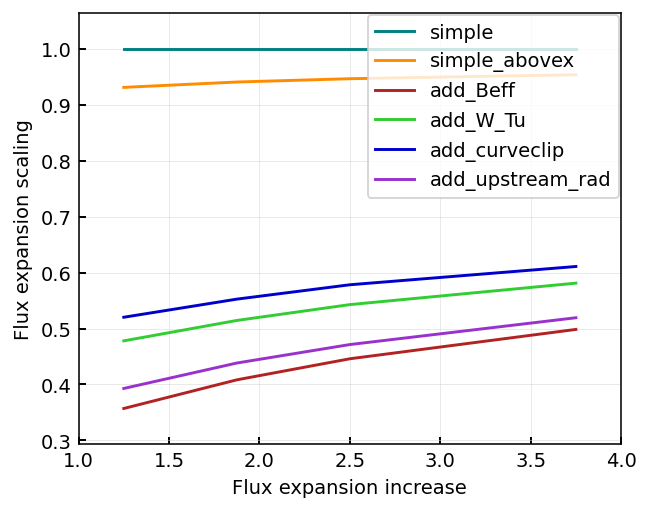

In [103]:
dflog = out.copy().drop("param", axis = 1)
dflog["param_rel"] = np.log(dflog["param_rel"])

for col in dflog.drop("param_rel", axis = 1).columns:
    
    dflog[col] = np.log(1/dflog[col])
    dflog[col] /= dflog["param_rel"]
    
dflog["param_rel"] = out["param_rel"]
dflog = dflog.iloc[1:]
dflog

fig, ax = plt.subplots()
for param in dflog.drop("param_rel", axis = 1).columns:
    ax.plot(dflog["param_rel"], dflog[param], label = param)
    
ax.set_xlabel("Flux expansion increase")
ax.set_ylabel("Flux expansion scaling")
ax.legend()

In [87]:
df2 = pd.DataFrame()

df2["param_log"] = np.log(out["param_rel"])
df2["simple_log"] =  np.log(out["simple"])

df2

,param_log,simple_log
0,0.000000,0.000000
1,0.223144,-0.223144
2,0.628609,-0.628609
3,0.916291,-0.916291
4,1.321756,-1.321756


In [80]:
np.log(1.25)

0.22314355131420976

In [78]:
out

,param,param_rel,simple,simple_abovex,add_Beff,add_W_Tu,add_curveclip,add_upstream_rad
0,0.8,1.000,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.250,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,1.5,1.875,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,2.0,2.500,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,3.0,3.750,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [76]:
np.log(out["param_rel"])

0    0.000000
1    0.223144
2    0.628609
3    0.916291
4    1.321756
Name: param_rel, dtype: float64

In [77]:
np.log(out["add_Beff"])

0    NaN
1   -inf
2   -inf
3   -inf
4   -inf
Name: add_Beff, dtype: float64

In [75]:
# Exponent = np.log(threshold) / np.log(fR)

out["param_rel"] = out["param"] / out["param"].iloc[0]
np.log(out["param_rel"]) / np.log(out["add_Beff"])

0    NaN
1   -0.0
2   -0.0
3   -0.0
4   -0.0
dtype: float64

In [61]:
out["simple_abovex"] / out["simple"]

0    1.000000
1    1.015381
2    1.037664
3    1.049671
4    1.062329
dtype: float64

dict_keys([0.8, 1, 1.5, 2, 3])

In [29]:
s = stores[0.8]
# stores.keys()
s.keys()
# s["crel"]

dict_keys(['Splot', 'SpolPlot', 'cvar', 'Sprofiles', 'Tprofiles', 'Rprofiles', 'Qprofiles', 'Spolprofiles', 'Btotprofiles', 'Bpolprofiles', 'Xpoints', 'Wradials', 'logs', 'crel', 'threshold', 'constants', 'radios', 'state'])

In [ ]:
get_front_widths(profiles[0], stores[0]

# Old

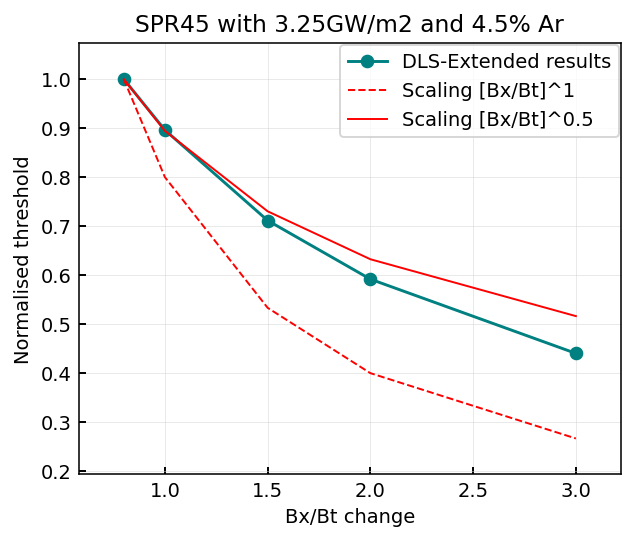

In [ ]:

profiles = store_profiles["BxBt"]
stores = store_stores["BxBt"]

df = pd.DataFrame()
df["BxBt"] = np.array([profiles[x].get_total_flux_expansion() for x in profiles])
df["thresholds"] = np.array([stores[x]["threshold"] for x in profiles])
df["improvement"] = df["thresholds"] / df["thresholds"].iloc[0]
df["scaling"] = df["BxBt"].iloc[0] / df["BxBt"]
df["scaling_custom"] = (df["BxBt"].iloc[0] / df["BxBt"])**0.5

fig, ax = plt.subplots()
style = dict(marker = "o")
ax.plot(df["BxBt"], df["improvement"], label = "DLS-Extended results", **style)
ax.plot(df["BxBt"], df["scaling_custom"], label = "Scaling [Bx/Bt]^0.5", lw = 1, c = "r")
ax.plot(df["BxBt"], df["scaling"], label = "Scaling [Bx/Bt]^1", lw = 1, c = "r", ls = "--")

ax.set_xlabel("Bx/Bt change")
ax.set_ylabel("Normalised threshold")
ax.set_title("SPR45 with 3.25GW/m2 and 4.5% Ar")
ax.legend()

# Connection length

Text(0.5, 1.0, 'Connection length profiles')

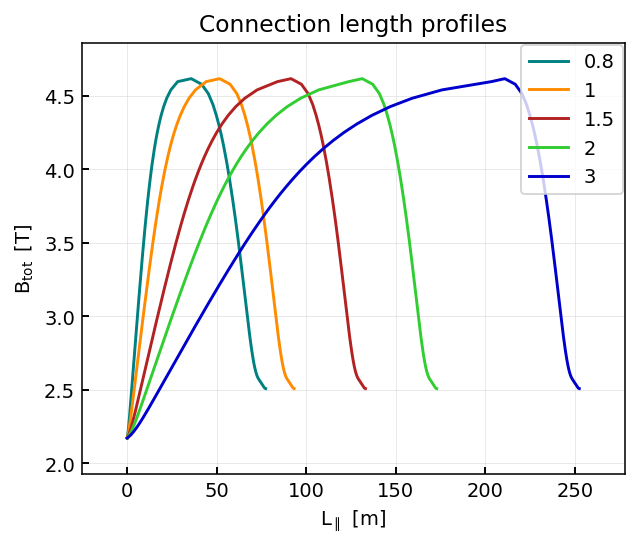

In [6]:
p = eqb["SPR45"]["ol"]

newp = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

list_Lc = [0.8, 1, 1.5, 2, 3]
profiles_Lc = {}

fig, ax = plt.subplots()

for Lc in list_Lc:
    profiles_Lc[Lc] = copy.deepcopy(newp)
    profiles_Lc[Lc].scale_Lc(scale_factor = Lc)
    
    p = profiles_Lc[Lc]
    ax.plot(profiles_Lc[Lc]["S"], profiles_Lc[Lc]["Btot"], label = Lc)
    # ax.plot(p["S"][p["Xpoint"]], p["Btot"][p["Xpoint"]], marker = "x", ms = 5, c = "k")
    
# ax.vlines(newp["S"][newp["Xpoint"]], 1, 6, color = "k", lw = 1.0, linestyle = "--")
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Connection length profiles")

In [8]:
df = get_detachment_scalings(profiles_Lc, store_Lc)
x = df["L"]

fig, axes = plt.subplots(dpi = 160, figsize = (5,4))
ms = 0
axes.set_title(r"Connection length scan")
threshcalcs = plot_threshcalcs(df, axes)
axes.plot(x, df["thresholds"]/df["thresholds"][0], marker = "*", lw = 0, ms = 10, c = "darkorange", alpha = 0.7, label = "DLS-Extended")

axes.set_xlabel("Total connection length [m]")
axes.set_ylabel("Relative threshold change")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.02), ncols = 1)
axes.spines["top"].set_visible(True)
axes.spines["right"].set_visible(True)

NameError: name 'store_Lc' is not defined